In [1]:
# change the colab's working path
from google.colab import drive
drive.mount('/content/drive')
import os
notebook_path = os.path.abspath("/content/drive/MyDrive/cw2")
os.chdir(notebook_path)
for item in os.listdir(os.getcwd()):
    print(item)

Mounted at /content/drive
emojis_am.zip
cw2_cs5242.pdf
emojis_am
generated_images
best_5
cw2.ipynb


In [2]:
import os
import time
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class Args:
    epochs = 10000
    batch_size = 64
    lr = 2e-4
    latent_dim = 128
    img_size = 128
    channels = 3
    save_interval = 100
    log_interval = 100
    checkpoint = 1000
    
args = Args()
img_shape = (args.channels, args.img_size, args.img_size)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 128, 128])


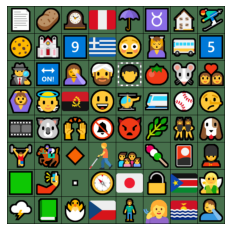

In [3]:
from torch.utils.data import Dataset
from torchvision.utils import make_grid,save_image
from torchvision import transforms
from PIL import Image
import os
import math

class EmojiDataset(Dataset):
    def __init__(self, root_dir, lst_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # read the files
        with open(lst_file, 'r') as f:
            self.file_list = [line.strip() for line in f.readlines()]
    
    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.root_dir, file_name)
        
        # read the imgs
        with open(file_path, 'rb') as f:
            img = Image.open(f).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img
    
    def __len__(self):
        return len(self.file_list)

# set the file dir
data_path = 'emojis_am'
lst_file = 'emojis_am/lst.txt'
PIL2tensor = transforms.ToTensor()
tensor2PIL = transforms.ToPILImage()
# create the dataset object
dataset = EmojiDataset(root_dir=data_path, lst_file=lst_file, transform=PIL2tensor)

# create the data loader
loader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=10, drop_last=True)
num_iters = len(loader)
# try to fetch some imgs to see
data = next(iter(loader))
print(data.shape)
# make the img gird
grid_img = make_grid(data, nrow=int(math.sqrt(args.batch_size)))
img = tensor2PIL(grid_img)

# show image grid
def display_image(img, title=None):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

display_image(img)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()

        self.init_size = img_size[-1] // 4
        self.fc = nn.Linear(latent_dim, 128 * self.init_size ** 2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_size[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()

        def discriminator_block(in_filters, out_filters, norm=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if norm:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_size[0], 16),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size[-1] // 2 ** 4 
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.flatten(1)
        pred = self.adv_layer(out)
        return pred

In [ ]:
model_g = Generator(args.latent_dim, img_shape).to(device)
model_d = Discriminator(img_shape).to(device)

In [ ]:
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if f == '':
        f = '0ms'
    return f

criterion = nn.BCELoss().to(device)
optimizer_G = torch.optim.Adam(model_g.parameters(), lr=args.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(model_d.parameters(), lr=args.lr, betas=(0.5, 0.999))
model_g.train()
model_d.train()
epochs = args.epochs

In [ ]:
# load the model
model_d_dir = "./generated_images/2023-03-10_18-36-51/model_d.pth"
model_g_dir = "./generated_images/2023-03-10_18-36-51/model_g.pth"
model_d.load_state_dict(torch.load(model_d_dir))
model_g.load_state_dict(torch.load(model_g_dir))


<All keys matched successfully>

Epoch [10/10000][28/28] - loss_g: 12.0809, loss_d: 0.0033
Epoch [20/10000][28/28] - loss_g: 13.0906, loss_d: 0.0009
Epoch [30/10000][28/28] - loss_g: 7.3615, loss_d: 0.0013
Epoch [40/10000][28/28] - loss_g: 13.8896, loss_d: 0.0097
Epoch [50/10000][28/28] - loss_g: 14.8893, loss_d: 0.0006
Epoch [60/10000][28/28] - loss_g: 11.5173, loss_d: 0.0004
Epoch [70/10000][28/28] - loss_g: 11.0876, loss_d: 0.0009
Epoch [80/10000][28/28] - loss_g: 6.9233, loss_d: 0.0014
Epoch [90/10000][28/28] - loss_g: 16.4948, loss_d: 0.0000
Epoch [100/10000][28/28] - loss_g: 12.6111, loss_d: 0.0033


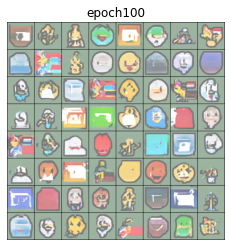

Epoch [110/10000][28/28] - loss_g: 11.0228, loss_d: 0.0090
Epoch [120/10000][28/28] - loss_g: 4.4484, loss_d: 0.2557
Epoch [130/10000][28/28] - loss_g: 11.4328, loss_d: 0.0002
Epoch [140/10000][28/28] - loss_g: 12.3677, loss_d: 0.0001
Epoch [150/10000][28/28] - loss_g: 9.2764, loss_d: 0.0010
Epoch [160/10000][28/28] - loss_g: 8.5911, loss_d: 0.0000
Epoch [170/10000][28/28] - loss_g: 5.7401, loss_d: 0.1602
Epoch [180/10000][28/28] - loss_g: 12.6630, loss_d: 0.0013
Epoch [190/10000][28/28] - loss_g: 11.9692, loss_d: 0.0039
Epoch [200/10000][28/28] - loss_g: 12.6589, loss_d: 1.4540


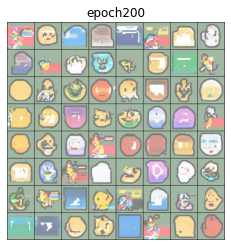

Epoch [210/10000][28/28] - loss_g: 14.0024, loss_d: 0.0004
Epoch [220/10000][28/28] - loss_g: 8.2939, loss_d: 0.0001
Epoch [230/10000][28/28] - loss_g: 10.3167, loss_d: 0.0077
Epoch [240/10000][28/28] - loss_g: 18.7708, loss_d: 0.0001
Epoch [250/10000][28/28] - loss_g: 7.0337, loss_d: 0.0001
Epoch [260/10000][28/28] - loss_g: 5.9522, loss_d: 0.0824
Epoch [270/10000][28/28] - loss_g: 13.4569, loss_d: 0.0070
Epoch [280/10000][28/28] - loss_g: 13.0652, loss_d: 0.0003
Epoch [290/10000][28/28] - loss_g: 10.7092, loss_d: 0.0001
Epoch [300/10000][28/28] - loss_g: 11.3016, loss_d: 0.0003


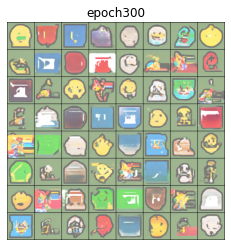

Epoch [310/10000][28/28] - loss_g: 16.1417, loss_d: 0.0007
Epoch [320/10000][28/28] - loss_g: 12.1110, loss_d: 0.0000
Epoch [330/10000][28/28] - loss_g: 12.9406, loss_d: 0.0001
Epoch [340/10000][28/28] - loss_g: 12.4408, loss_d: 0.0001
Epoch [350/10000][28/28] - loss_g: 12.2632, loss_d: 0.0008
Epoch [360/10000][28/28] - loss_g: 14.9487, loss_d: 0.0135
Epoch [370/10000][28/28] - loss_g: 15.1675, loss_d: 0.0050
Epoch [380/10000][28/28] - loss_g: 16.0313, loss_d: 0.0000
Epoch [390/10000][28/28] - loss_g: 11.3530, loss_d: 0.0049
Epoch [400/10000][28/28] - loss_g: 10.8440, loss_d: 0.0036


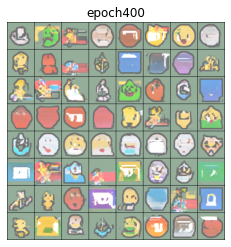

Epoch [410/10000][28/28] - loss_g: 13.5970, loss_d: 0.0015
Epoch [420/10000][28/28] - loss_g: 15.2222, loss_d: 0.0001
Epoch [430/10000][28/28] - loss_g: 26.3010, loss_d: 0.0028
Epoch [440/10000][28/28] - loss_g: 9.6770, loss_d: 0.0007
Epoch [450/10000][28/28] - loss_g: 11.4658, loss_d: 0.0073
Epoch [460/10000][28/28] - loss_g: 14.1108, loss_d: 0.0136
Epoch [470/10000][28/28] - loss_g: 9.6966, loss_d: 0.0154
Epoch [480/10000][28/28] - loss_g: 11.2107, loss_d: 0.0008
Epoch [490/10000][28/28] - loss_g: 2.0798, loss_d: 0.0466
Epoch [500/10000][28/28] - loss_g: 15.1048, loss_d: 0.0002


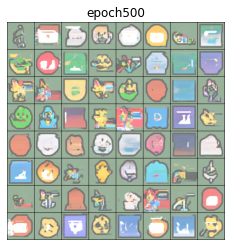

Epoch [510/10000][28/28] - loss_g: 13.0606, loss_d: 0.0167
Epoch [520/10000][28/28] - loss_g: 15.4586, loss_d: 0.0002
Epoch [530/10000][28/28] - loss_g: 14.7240, loss_d: 0.0005
Epoch [540/10000][28/28] - loss_g: 12.4607, loss_d: 0.2829
Epoch [550/10000][28/28] - loss_g: 8.2753, loss_d: 0.0000
Epoch [560/10000][28/28] - loss_g: 12.4139, loss_d: 0.0000
Epoch [570/10000][28/28] - loss_g: 5.7966, loss_d: 0.0000
Epoch [580/10000][28/28] - loss_g: 12.2681, loss_d: 0.0011
Epoch [590/10000][28/28] - loss_g: 15.7699, loss_d: 0.0001
Epoch [600/10000][28/28] - loss_g: 10.8069, loss_d: 0.0001


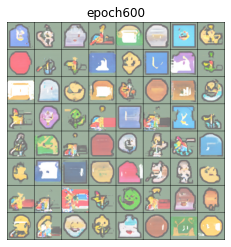

Epoch [610/10000][28/28] - loss_g: 12.2159, loss_d: 0.0195
Epoch [620/10000][28/28] - loss_g: 15.0510, loss_d: 0.0001
Epoch [630/10000][28/28] - loss_g: 14.8400, loss_d: 0.0017
Epoch [640/10000][28/28] - loss_g: 9.8945, loss_d: 0.0011
Epoch [650/10000][28/28] - loss_g: 12.0787, loss_d: 0.0083
Epoch [660/10000][28/28] - loss_g: 16.0737, loss_d: 0.0013
Epoch [670/10000][28/28] - loss_g: 10.9707, loss_d: 0.0007
Epoch [680/10000][28/28] - loss_g: 17.0098, loss_d: 0.0000
Epoch [690/10000][28/28] - loss_g: 9.5967, loss_d: 0.0002
Epoch [700/10000][28/28] - loss_g: 13.5803, loss_d: 0.0000


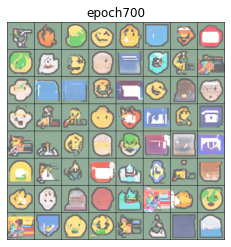

Epoch [710/10000][28/28] - loss_g: 4.7963, loss_d: 0.3467
Epoch [720/10000][28/28] - loss_g: 13.4925, loss_d: 0.0260
Epoch [730/10000][28/28] - loss_g: 14.9956, loss_d: 0.0173
Epoch [740/10000][28/28] - loss_g: 14.4819, loss_d: 0.0002
Epoch [750/10000][28/28] - loss_g: 16.8652, loss_d: 0.0020
Epoch [760/10000][28/28] - loss_g: 8.0545, loss_d: 0.0001
Epoch [770/10000][28/28] - loss_g: 7.2757, loss_d: 0.0001
Epoch [780/10000][28/28] - loss_g: 18.0618, loss_d: 0.0000
Epoch [790/10000][28/28] - loss_g: 13.6954, loss_d: 0.0013
Epoch [800/10000][28/28] - loss_g: 13.8436, loss_d: 0.0001


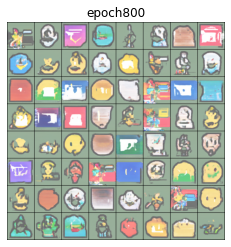

Epoch [810/10000][28/28] - loss_g: 8.9749, loss_d: 0.0014
Epoch [820/10000][28/28] - loss_g: 10.8439, loss_d: 0.0022
Epoch [830/10000][28/28] - loss_g: 6.1523, loss_d: 0.0015
Epoch [840/10000][28/28] - loss_g: 13.8804, loss_d: 0.0006
Epoch [850/10000][28/28] - loss_g: 12.6536, loss_d: 0.1219
Epoch [860/10000][28/28] - loss_g: 16.1996, loss_d: 0.0073
Epoch [870/10000][28/28] - loss_g: 10.8573, loss_d: 0.0003
Epoch [880/10000][28/28] - loss_g: 9.0622, loss_d: 0.0012
Epoch [890/10000][28/28] - loss_g: 13.5150, loss_d: 0.0001
Epoch [900/10000][28/28] - loss_g: 12.6791, loss_d: 0.0253


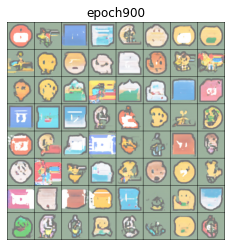

Epoch [910/10000][28/28] - loss_g: 9.9447, loss_d: 0.0000
Epoch [920/10000][28/28] - loss_g: 10.9653, loss_d: 0.0128
Epoch [930/10000][28/28] - loss_g: 11.0583, loss_d: 0.0520
Epoch [940/10000][28/28] - loss_g: 10.3412, loss_d: 0.0000
Epoch [950/10000][28/28] - loss_g: 14.6822, loss_d: 0.0013
Epoch [960/10000][28/28] - loss_g: 13.1704, loss_d: 0.0010
Epoch [970/10000][28/28] - loss_g: 16.3011, loss_d: 0.0124
Epoch [980/10000][28/28] - loss_g: 14.5287, loss_d: 0.0210
Epoch [990/10000][28/28] - loss_g: 13.6358, loss_d: 0.0006
Epoch [1000/10000][28/28] - loss_g: 14.5997, loss_d: 0.0130


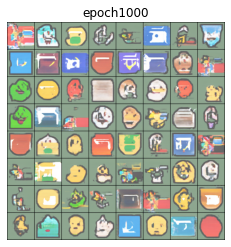

checkpoint
Epoch [1010/10000][28/28] - loss_g: 13.4565, loss_d: 0.0102
Epoch [1020/10000][28/28] - loss_g: 12.2212, loss_d: 0.0014
Epoch [1030/10000][28/28] - loss_g: 12.6444, loss_d: 0.0010
Epoch [1040/10000][28/28] - loss_g: 9.3571, loss_d: 0.0013
Epoch [1050/10000][28/28] - loss_g: 6.9157, loss_d: 0.0114
Epoch [1060/10000][28/28] - loss_g: 10.5671, loss_d: 0.0000
Epoch [1070/10000][28/28] - loss_g: 7.7861, loss_d: 0.0007
Epoch [1080/10000][28/28] - loss_g: 15.8200, loss_d: 0.0002
Epoch [1090/10000][28/28] - loss_g: 13.0677, loss_d: 0.0003
Epoch [1100/10000][28/28] - loss_g: 10.2904, loss_d: 0.0002


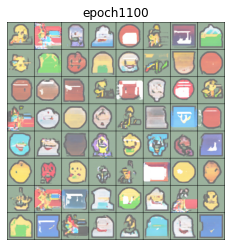

Epoch [1110/10000][28/28] - loss_g: 12.3250, loss_d: 0.0002
Epoch [1120/10000][28/28] - loss_g: 11.9540, loss_d: 0.0099
Epoch [1130/10000][28/28] - loss_g: 11.0327, loss_d: 0.0050
Epoch [1140/10000][28/28] - loss_g: 13.3209, loss_d: 0.0000
Epoch [1150/10000][28/28] - loss_g: 11.5042, loss_d: 0.0001
Epoch [1160/10000][28/28] - loss_g: 12.2518, loss_d: 0.0001
Epoch [1170/10000][28/28] - loss_g: 13.4314, loss_d: 0.0004
Epoch [1180/10000][28/28] - loss_g: 10.5202, loss_d: 0.0000
Epoch [1190/10000][28/28] - loss_g: 13.0748, loss_d: 0.0013
Epoch [1200/10000][28/28] - loss_g: 12.4502, loss_d: 0.0136


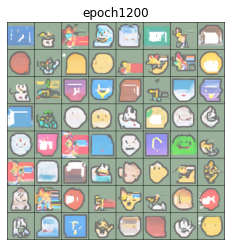

Epoch [1210/10000][28/28] - loss_g: 16.1343, loss_d: 0.0037
Epoch [1220/10000][28/28] - loss_g: 13.0753, loss_d: 0.0002
Epoch [1230/10000][28/28] - loss_g: 8.4077, loss_d: 0.0001
Epoch [1240/10000][28/28] - loss_g: 12.3487, loss_d: 0.0099
Epoch [1250/10000][28/28] - loss_g: 11.6445, loss_d: 0.0009
Epoch [1260/10000][28/28] - loss_g: 11.1743, loss_d: 0.0001
Epoch [1270/10000][28/28] - loss_g: 13.6199, loss_d: 0.0001
Epoch [1280/10000][28/28] - loss_g: 11.0872, loss_d: 0.0050
Epoch [1290/10000][28/28] - loss_g: 11.5573, loss_d: 0.0001
Epoch [1300/10000][28/28] - loss_g: 10.5828, loss_d: 0.0007


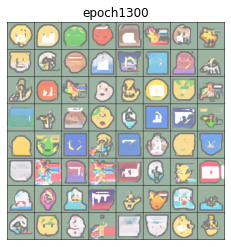

Epoch [1310/10000][28/28] - loss_g: 17.6800, loss_d: 0.0066
Epoch [1320/10000][28/28] - loss_g: 11.6829, loss_d: 0.0289
Epoch [1330/10000][28/28] - loss_g: 7.9210, loss_d: 0.0003
Epoch [1340/10000][28/28] - loss_g: 13.1569, loss_d: 0.0000
Epoch [1350/10000][28/28] - loss_g: 14.7230, loss_d: 0.0013
Epoch [1360/10000][28/28] - loss_g: 15.8987, loss_d: 0.0000
Epoch [1370/10000][28/28] - loss_g: 14.0578, loss_d: 0.0164
Epoch [1380/10000][28/28] - loss_g: 14.1489, loss_d: 0.0002
Epoch [1390/10000][28/28] - loss_g: 12.4560, loss_d: 0.0017
Epoch [1400/10000][28/28] - loss_g: 12.1260, loss_d: 0.0001


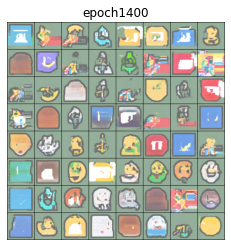

Epoch [1410/10000][28/28] - loss_g: 9.1693, loss_d: 0.0023
Epoch [1420/10000][28/28] - loss_g: 10.2110, loss_d: 0.0004
Epoch [1430/10000][28/28] - loss_g: 14.5230, loss_d: 0.0003
Epoch [1440/10000][28/28] - loss_g: 13.1483, loss_d: 0.0001
Epoch [1450/10000][28/28] - loss_g: 12.7539, loss_d: 0.0001
Epoch [1460/10000][28/28] - loss_g: 3.6167, loss_d: 0.0002
Epoch [1470/10000][28/28] - loss_g: 9.1206, loss_d: 0.0001
Epoch [1480/10000][28/28] - loss_g: 11.1956, loss_d: 0.0050
Epoch [1490/10000][28/28] - loss_g: 16.2556, loss_d: 0.0040
Epoch [1500/10000][28/28] - loss_g: 8.9033, loss_d: 0.0019


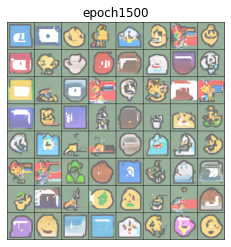

Epoch [1510/10000][28/28] - loss_g: 13.5438, loss_d: 0.0001
Epoch [1520/10000][28/28] - loss_g: 10.9684, loss_d: 0.0009
Epoch [1530/10000][28/28] - loss_g: 10.5123, loss_d: 0.0345
Epoch [1540/10000][28/28] - loss_g: 11.9579, loss_d: 0.0035
Epoch [1550/10000][28/28] - loss_g: 12.9306, loss_d: 0.0002
Epoch [1560/10000][28/28] - loss_g: 15.0846, loss_d: 0.0000
Epoch [1570/10000][28/28] - loss_g: 15.0861, loss_d: 0.0003
Epoch [1580/10000][28/28] - loss_g: 12.4478, loss_d: 0.0011
Epoch [1590/10000][28/28] - loss_g: 12.1155, loss_d: 0.0089
Epoch [1600/10000][28/28] - loss_g: 10.7303, loss_d: 0.0006


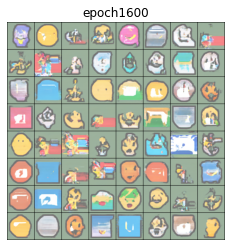

Epoch [1610/10000][28/28] - loss_g: 13.9079, loss_d: 0.0001
Epoch [1620/10000][28/28] - loss_g: 14.3192, loss_d: 0.0001
Epoch [1630/10000][28/28] - loss_g: 10.5339, loss_d: 0.0382
Epoch [1640/10000][28/28] - loss_g: 15.4766, loss_d: 0.0067
Epoch [1650/10000][28/28] - loss_g: 9.8160, loss_d: 0.0285
Epoch [1660/10000][28/28] - loss_g: 18.9785, loss_d: 0.0003
Epoch [1670/10000][28/28] - loss_g: 11.1304, loss_d: 0.0010
Epoch [1680/10000][28/28] - loss_g: 14.5304, loss_d: 0.0141
Epoch [1690/10000][28/28] - loss_g: 8.4598, loss_d: 0.0118
Epoch [1700/10000][28/28] - loss_g: 10.3478, loss_d: 0.0311


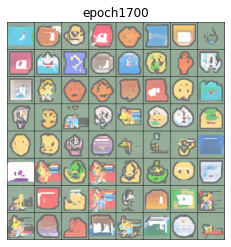

Epoch [1710/10000][28/28] - loss_g: 12.3354, loss_d: 0.0018
Epoch [1720/10000][28/28] - loss_g: 19.8469, loss_d: 0.0001
Epoch [1730/10000][28/28] - loss_g: 15.2693, loss_d: 0.0039
Epoch [1740/10000][28/28] - loss_g: 8.7988, loss_d: 0.0007
Epoch [1750/10000][28/28] - loss_g: 16.3148, loss_d: 0.0007
Epoch [1760/10000][28/28] - loss_g: 11.8462, loss_d: 0.0002
Epoch [1770/10000][28/28] - loss_g: 12.8800, loss_d: 0.0008
Epoch [1780/10000][28/28] - loss_g: 8.9003, loss_d: 0.0004
Epoch [1790/10000][28/28] - loss_g: 10.1478, loss_d: 0.0174
Epoch [1800/10000][28/28] - loss_g: 16.5740, loss_d: 0.0142


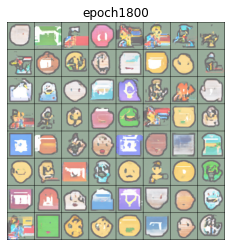

Epoch [1810/10000][28/28] - loss_g: 15.4419, loss_d: 0.0009
Epoch [1820/10000][28/28] - loss_g: 17.0659, loss_d: 0.0045
Epoch [1830/10000][28/28] - loss_g: 16.4686, loss_d: 0.0116
Epoch [1840/10000][28/28] - loss_g: 15.4575, loss_d: 0.0000
Epoch [1850/10000][28/28] - loss_g: 12.0290, loss_d: 0.0009
Epoch [1860/10000][28/28] - loss_g: 16.3177, loss_d: 0.0046
Epoch [1870/10000][28/28] - loss_g: 12.8913, loss_d: 0.0042
Epoch [1880/10000][28/28] - loss_g: 6.9813, loss_d: 0.0001
Epoch [1890/10000][28/28] - loss_g: 13.4754, loss_d: 0.0004
Epoch [1900/10000][28/28] - loss_g: 15.7227, loss_d: 0.0002


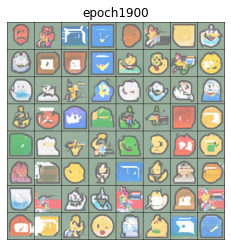

Epoch [1910/10000][28/28] - loss_g: 14.5539, loss_d: 0.0076
Epoch [1920/10000][28/28] - loss_g: 12.7306, loss_d: 0.0009
Epoch [1930/10000][28/28] - loss_g: 12.1029, loss_d: 0.0077
Epoch [1940/10000][28/28] - loss_g: 10.9882, loss_d: 0.0035
Epoch [1950/10000][28/28] - loss_g: 10.9773, loss_d: 0.0003
Epoch [1960/10000][28/28] - loss_g: 15.4858, loss_d: 0.0001
Epoch [1970/10000][28/28] - loss_g: 10.5575, loss_d: 0.0000
Epoch [1980/10000][28/28] - loss_g: 21.2103, loss_d: 0.0001
Epoch [1990/10000][28/28] - loss_g: 11.4831, loss_d: 0.0000
Epoch [2000/10000][28/28] - loss_g: 10.0322, loss_d: 0.0160


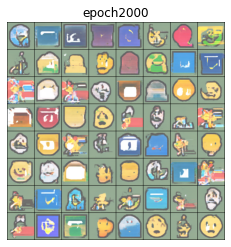

checkpoint
Epoch [2010/10000][28/28] - loss_g: 9.0177, loss_d: 0.0521
Epoch [2020/10000][28/28] - loss_g: 17.9866, loss_d: 0.0015
Epoch [2030/10000][28/28] - loss_g: 11.8847, loss_d: 0.0008
Epoch [2040/10000][28/28] - loss_g: 12.2629, loss_d: 0.0002
Epoch [2050/10000][28/28] - loss_g: 16.5852, loss_d: 0.0099
Epoch [2060/10000][28/28] - loss_g: 14.1169, loss_d: 0.0000
Epoch [2070/10000][28/28] - loss_g: 12.8901, loss_d: 0.0009
Epoch [2080/10000][28/28] - loss_g: 12.6528, loss_d: 0.0023
Epoch [2090/10000][28/28] - loss_g: 15.1150, loss_d: 0.0007
Epoch [2100/10000][28/28] - loss_g: 16.0110, loss_d: 0.0042


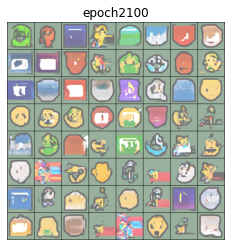

Epoch [2110/10000][28/28] - loss_g: 11.1738, loss_d: 0.0009
Epoch [2120/10000][28/28] - loss_g: 13.7305, loss_d: 0.0035
Epoch [2130/10000][28/28] - loss_g: 12.0780, loss_d: 0.0000
Epoch [2140/10000][28/28] - loss_g: 9.2252, loss_d: 0.0063
Epoch [2150/10000][28/28] - loss_g: 8.4523, loss_d: 0.0001
Epoch [2160/10000][28/28] - loss_g: 11.9528, loss_d: 0.0100
Epoch [2170/10000][28/28] - loss_g: 12.1870, loss_d: 0.0000
Epoch [2180/10000][28/28] - loss_g: 11.1752, loss_d: 0.0005
Epoch [2190/10000][28/28] - loss_g: 13.4843, loss_d: 0.0002
Epoch [2200/10000][28/28] - loss_g: 9.7706, loss_d: 0.0007


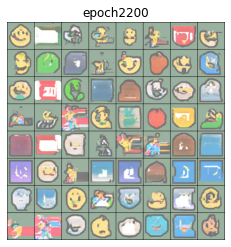

Epoch [2210/10000][28/28] - loss_g: 13.3772, loss_d: 0.0032
Epoch [2220/10000][28/28] - loss_g: 7.9094, loss_d: 0.0042
Epoch [2230/10000][28/28] - loss_g: 16.1226, loss_d: 0.0013
Epoch [2240/10000][28/28] - loss_g: 11.9011, loss_d: 0.0163
Epoch [2250/10000][28/28] - loss_g: 11.7375, loss_d: 0.0003
Epoch [2260/10000][28/28] - loss_g: 14.1883, loss_d: 0.0261
Epoch [2270/10000][28/28] - loss_g: 14.0920, loss_d: 0.0001
Epoch [2280/10000][28/28] - loss_g: 20.3081, loss_d: 0.0003
Epoch [2290/10000][28/28] - loss_g: 7.7646, loss_d: 0.0789
Epoch [2300/10000][28/28] - loss_g: 12.9685, loss_d: 0.0006


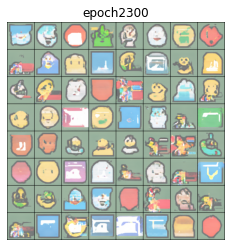

Epoch [2310/10000][28/28] - loss_g: 8.1390, loss_d: 0.0651
Epoch [2320/10000][28/28] - loss_g: 6.1967, loss_d: 0.0001
Epoch [2330/10000][28/28] - loss_g: 11.4073, loss_d: 0.0306
Epoch [2340/10000][28/28] - loss_g: 13.5815, loss_d: 0.0002
Epoch [2350/10000][28/28] - loss_g: 9.5181, loss_d: 0.0007
Epoch [2360/10000][28/28] - loss_g: 14.9190, loss_d: 0.0250
Epoch [2370/10000][28/28] - loss_g: 8.6162, loss_d: 0.0064
Epoch [2380/10000][28/28] - loss_g: 12.6570, loss_d: 0.0002
Epoch [2390/10000][28/28] - loss_g: 11.5906, loss_d: 0.0386
Epoch [2400/10000][28/28] - loss_g: 11.6752, loss_d: 0.0011


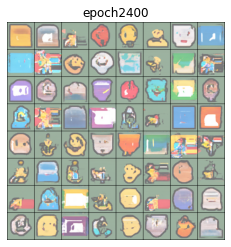

Epoch [2410/10000][28/28] - loss_g: 6.9702, loss_d: 0.0075
Epoch [2420/10000][28/28] - loss_g: 12.0981, loss_d: 0.0099
Epoch [2430/10000][28/28] - loss_g: 10.3528, loss_d: 0.0189
Epoch [2440/10000][28/28] - loss_g: 8.7393, loss_d: 0.0021
Epoch [2450/10000][28/28] - loss_g: 15.1792, loss_d: 0.0006
Epoch [2460/10000][28/28] - loss_g: 14.8678, loss_d: 0.0003
Epoch [2470/10000][28/28] - loss_g: 12.8864, loss_d: 0.0006
Epoch [2480/10000][28/28] - loss_g: 11.7318, loss_d: 0.0004
Epoch [2490/10000][28/28] - loss_g: 8.2164, loss_d: 0.0001
Epoch [2500/10000][28/28] - loss_g: 8.0435, loss_d: 0.0046


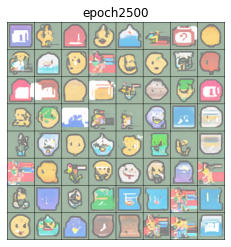

Epoch [2510/10000][28/28] - loss_g: 10.9721, loss_d: 0.0002
Epoch [2520/10000][28/28] - loss_g: 13.1471, loss_d: 0.0375
Epoch [2530/10000][28/28] - loss_g: 13.4377, loss_d: 0.0001
Epoch [2540/10000][28/28] - loss_g: 10.2051, loss_d: 0.0003
Epoch [2550/10000][28/28] - loss_g: 5.8675, loss_d: 0.0004
Epoch [2560/10000][28/28] - loss_g: 12.1747, loss_d: 0.0008
Epoch [2570/10000][28/28] - loss_g: 11.7789, loss_d: 0.0042
Epoch [2580/10000][28/28] - loss_g: 12.7993, loss_d: 0.0002
Epoch [2590/10000][28/28] - loss_g: 12.3214, loss_d: 0.0005
Epoch [2600/10000][28/28] - loss_g: 10.5031, loss_d: 0.0000


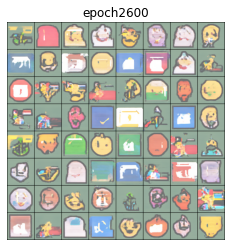

Epoch [2610/10000][28/28] - loss_g: 14.9758, loss_d: 0.0060
Epoch [2620/10000][28/28] - loss_g: 6.4458, loss_d: 0.0154
Epoch [2630/10000][28/28] - loss_g: 12.4259, loss_d: 0.0041
Epoch [2640/10000][28/28] - loss_g: 11.5498, loss_d: 0.0104
Epoch [2650/10000][28/28] - loss_g: 9.4033, loss_d: 0.0000
Epoch [2660/10000][28/28] - loss_g: 4.6621, loss_d: 0.0000
Epoch [2670/10000][28/28] - loss_g: 12.5649, loss_d: 0.0087
Epoch [2680/10000][28/28] - loss_g: 17.3021, loss_d: 0.0092
Epoch [2690/10000][28/28] - loss_g: 9.9428, loss_d: 0.0004
Epoch [2700/10000][28/28] - loss_g: 15.4881, loss_d: 0.0000


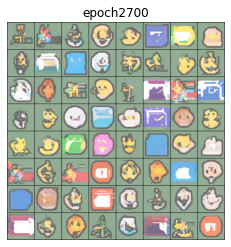

Epoch [2710/10000][28/28] - loss_g: 12.1820, loss_d: 0.0001
Epoch [2720/10000][28/28] - loss_g: 16.2622, loss_d: 0.0011
Epoch [2730/10000][28/28] - loss_g: 16.8408, loss_d: 0.0000
Epoch [2740/10000][28/28] - loss_g: 14.5613, loss_d: 0.2812
Epoch [2750/10000][28/28] - loss_g: 11.1397, loss_d: 0.0001
Epoch [2760/10000][28/28] - loss_g: 11.1853, loss_d: 0.0004
Epoch [2770/10000][28/28] - loss_g: 11.6822, loss_d: 0.0180
Epoch [2780/10000][28/28] - loss_g: 10.8988, loss_d: 0.0007
Epoch [2790/10000][28/28] - loss_g: 14.3583, loss_d: 0.0002
Epoch [2800/10000][28/28] - loss_g: 10.0866, loss_d: 0.0550


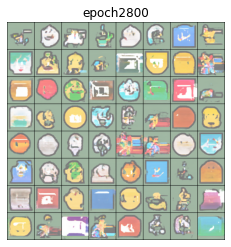

Epoch [2810/10000][28/28] - loss_g: 10.8524, loss_d: 0.0000
Epoch [2820/10000][28/28] - loss_g: 9.4169, loss_d: 0.0001
Epoch [2830/10000][28/28] - loss_g: 22.4401, loss_d: 0.0049
Epoch [2840/10000][28/28] - loss_g: 12.7125, loss_d: 0.0001
Epoch [2850/10000][28/28] - loss_g: 15.9499, loss_d: 0.1164
Epoch [2860/10000][28/28] - loss_g: 17.4108, loss_d: 0.0017
Epoch [2870/10000][28/28] - loss_g: 7.8153, loss_d: 0.0032
Epoch [2880/10000][28/28] - loss_g: 4.9033, loss_d: 0.0077
Epoch [2890/10000][28/28] - loss_g: 11.5947, loss_d: 0.0007
Epoch [2900/10000][28/28] - loss_g: 14.0845, loss_d: 0.0000


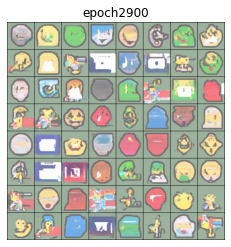

Epoch [2910/10000][28/28] - loss_g: 12.9587, loss_d: 0.0001
Epoch [2920/10000][28/28] - loss_g: 14.8785, loss_d: 0.0001
Epoch [2930/10000][28/28] - loss_g: 17.4103, loss_d: 0.0003
Epoch [2940/10000][28/28] - loss_g: 9.8881, loss_d: 0.0017
Epoch [2950/10000][28/28] - loss_g: 9.4102, loss_d: 0.0015
Epoch [2960/10000][28/28] - loss_g: 12.8288, loss_d: 0.0157
Epoch [2970/10000][28/28] - loss_g: 14.4178, loss_d: 0.0009
Epoch [2980/10000][28/28] - loss_g: 8.4924, loss_d: 0.0092
Epoch [2990/10000][28/28] - loss_g: 23.9766, loss_d: 0.0001
Epoch [3000/10000][28/28] - loss_g: 13.4958, loss_d: 0.0000


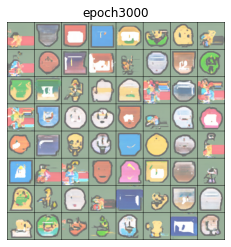

checkpoint
Epoch [3010/10000][28/28] - loss_g: 9.6494, loss_d: 0.0000
Epoch [3020/10000][28/28] - loss_g: 9.5014, loss_d: 0.0018
Epoch [3030/10000][28/28] - loss_g: 11.0079, loss_d: 0.0025
Epoch [3040/10000][28/28] - loss_g: 10.5418, loss_d: 0.0001
Epoch [3050/10000][28/28] - loss_g: 9.8981, loss_d: 0.0137
Epoch [3060/10000][28/28] - loss_g: 15.4832, loss_d: 0.0000
Epoch [3070/10000][28/28] - loss_g: 13.1474, loss_d: 0.0983
Epoch [3080/10000][28/28] - loss_g: 10.2711, loss_d: 0.0000
Epoch [3090/10000][28/28] - loss_g: 14.4099, loss_d: 0.0001
Epoch [3100/10000][28/28] - loss_g: 9.5352, loss_d: 0.0101


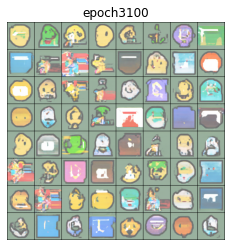

Epoch [3110/10000][28/28] - loss_g: 15.6382, loss_d: 0.0000
Epoch [3120/10000][28/28] - loss_g: 9.9881, loss_d: 0.0043
Epoch [3130/10000][28/28] - loss_g: 12.6296, loss_d: 0.0002
Epoch [3140/10000][28/28] - loss_g: 11.0520, loss_d: 0.0018
Epoch [3150/10000][28/28] - loss_g: 14.9747, loss_d: 0.0155
Epoch [3160/10000][28/28] - loss_g: 12.2959, loss_d: 0.0002
Epoch [3170/10000][28/28] - loss_g: 13.1272, loss_d: 0.0005
Epoch [3180/10000][28/28] - loss_g: 14.5739, loss_d: 0.7868
Epoch [3190/10000][28/28] - loss_g: 8.0871, loss_d: 0.0001
Epoch [3200/10000][28/28] - loss_g: 20.9041, loss_d: 0.0015


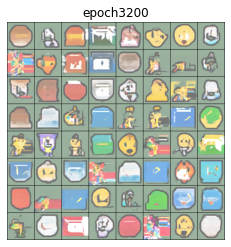

Epoch [3210/10000][28/28] - loss_g: 16.0834, loss_d: 0.0008
Epoch [3220/10000][28/28] - loss_g: 11.8090, loss_d: 0.0010
Epoch [3230/10000][28/28] - loss_g: 14.0784, loss_d: 0.5054
Epoch [3240/10000][28/28] - loss_g: 14.4334, loss_d: 0.0004
Epoch [3250/10000][28/28] - loss_g: 12.2278, loss_d: 0.0001
Epoch [3260/10000][28/28] - loss_g: 13.0796, loss_d: 0.0006
Epoch [3270/10000][28/28] - loss_g: 11.9230, loss_d: 0.0026
Epoch [3280/10000][28/28] - loss_g: 17.4358, loss_d: 0.0003
Epoch [3290/10000][28/28] - loss_g: 18.3450, loss_d: 0.0000
Epoch [3300/10000][28/28] - loss_g: 14.8754, loss_d: 0.0053


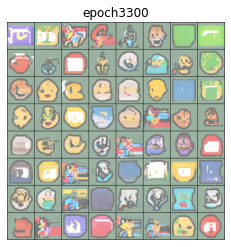

Epoch [3310/10000][28/28] - loss_g: 11.7217, loss_d: 0.0008
Epoch [3320/10000][28/28] - loss_g: 10.3815, loss_d: 0.0004
Epoch [3330/10000][28/28] - loss_g: 17.7407, loss_d: 0.0037
Epoch [3340/10000][28/28] - loss_g: 16.0048, loss_d: 0.0088
Epoch [3350/10000][28/28] - loss_g: 14.3557, loss_d: 0.0000
Epoch [3360/10000][28/28] - loss_g: 10.0487, loss_d: 0.0055
Epoch [3370/10000][28/28] - loss_g: 14.4187, loss_d: 0.0000
Epoch [3380/10000][28/28] - loss_g: 9.1306, loss_d: 0.0032
Epoch [3390/10000][28/28] - loss_g: 7.3819, loss_d: 0.0000
Epoch [3400/10000][28/28] - loss_g: 8.6849, loss_d: 0.0032


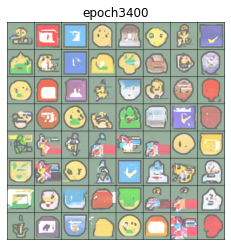

Epoch [3410/10000][28/28] - loss_g: 15.6201, loss_d: 0.0211
Epoch [3420/10000][28/28] - loss_g: 15.1669, loss_d: 0.0003
Epoch [3430/10000][28/28] - loss_g: 16.5440, loss_d: 0.0207
Epoch [3440/10000][28/28] - loss_g: 15.4476, loss_d: 0.0004
Epoch [3450/10000][28/28] - loss_g: 13.7223, loss_d: 0.0006
Epoch [3460/10000][28/28] - loss_g: 13.7331, loss_d: 0.0012
Epoch [3470/10000][28/28] - loss_g: 13.6188, loss_d: 0.0006
Epoch [3480/10000][28/28] - loss_g: 13.5369, loss_d: 0.0023
Epoch [3490/10000][28/28] - loss_g: 10.1511, loss_d: 0.0011
Epoch [3500/10000][28/28] - loss_g: 14.7908, loss_d: 0.0120


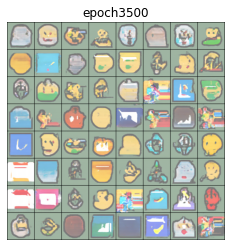

Epoch [3510/10000][28/28] - loss_g: 8.3585, loss_d: 0.0001
Epoch [3520/10000][28/28] - loss_g: 14.8110, loss_d: 0.0000
Epoch [3530/10000][28/28] - loss_g: 8.9541, loss_d: 0.0001
Epoch [3540/10000][28/28] - loss_g: 13.7968, loss_d: 0.0003
Epoch [3550/10000][28/28] - loss_g: 12.9963, loss_d: 0.0006
Epoch [3560/10000][28/28] - loss_g: 11.7993, loss_d: 0.0009
Epoch [3570/10000][28/28] - loss_g: 9.2237, loss_d: 0.0000
Epoch [3580/10000][28/28] - loss_g: 12.2820, loss_d: 0.0002
Epoch [3590/10000][28/28] - loss_g: 16.4023, loss_d: 0.0006
Epoch [3600/10000][28/28] - loss_g: 16.1831, loss_d: 0.0012


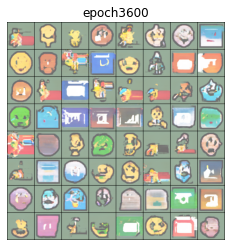

Epoch [3610/10000][28/28] - loss_g: 16.0922, loss_d: 0.0001
Epoch [3620/10000][28/28] - loss_g: 12.7916, loss_d: 0.0025
Epoch [3630/10000][28/28] - loss_g: 17.9164, loss_d: 0.0064
Epoch [3640/10000][28/28] - loss_g: 15.6514, loss_d: 0.0011
Epoch [3650/10000][28/28] - loss_g: 7.8322, loss_d: 0.0001
Epoch [3660/10000][28/28] - loss_g: 13.5895, loss_d: 0.0000
Epoch [3670/10000][28/28] - loss_g: 14.6404, loss_d: 0.0411
Epoch [3680/10000][28/28] - loss_g: 14.9149, loss_d: 0.0107
Epoch [3690/10000][28/28] - loss_g: 14.2315, loss_d: 0.0180
Epoch [3700/10000][28/28] - loss_g: 11.1723, loss_d: 0.0139


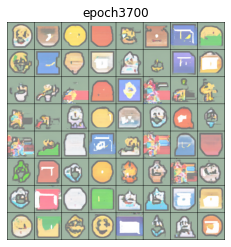

Epoch [3710/10000][28/28] - loss_g: 13.4419, loss_d: 0.0004
Epoch [3720/10000][28/28] - loss_g: 7.9074, loss_d: 0.0219
Epoch [3730/10000][28/28] - loss_g: 10.2953, loss_d: 0.0024
Epoch [3740/10000][28/28] - loss_g: 11.5420, loss_d: 0.0502
Epoch [3750/10000][28/28] - loss_g: 11.1762, loss_d: 0.0012
Epoch [3760/10000][28/28] - loss_g: 13.8806, loss_d: 0.0003
Epoch [3770/10000][28/28] - loss_g: 10.6760, loss_d: 0.0001
Epoch [3780/10000][28/28] - loss_g: 7.4544, loss_d: 0.0000
Epoch [3790/10000][28/28] - loss_g: 12.4692, loss_d: 0.0005
Epoch [3800/10000][28/28] - loss_g: 9.0846, loss_d: 0.0013


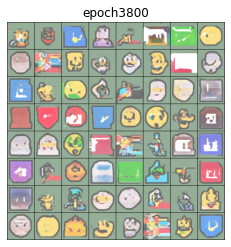

Epoch [3810/10000][28/28] - loss_g: 14.3087, loss_d: 0.0002
Epoch [3820/10000][28/28] - loss_g: 18.9423, loss_d: 0.0032
Epoch [3830/10000][28/28] - loss_g: 6.6565, loss_d: 0.0002
Epoch [3840/10000][28/28] - loss_g: 12.5955, loss_d: 0.0035
Epoch [3850/10000][28/28] - loss_g: 10.5194, loss_d: 0.0006
Epoch [3860/10000][28/28] - loss_g: 8.6851, loss_d: 0.0000
Epoch [3870/10000][28/28] - loss_g: 16.9239, loss_d: 0.0006
Epoch [3880/10000][28/28] - loss_g: 14.7033, loss_d: 0.0018
Epoch [3890/10000][28/28] - loss_g: 15.5255, loss_d: 0.0000
Epoch [3900/10000][28/28] - loss_g: 15.0802, loss_d: 0.0054


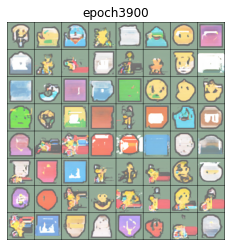

Epoch [3910/10000][28/28] - loss_g: 16.0311, loss_d: 0.0088
Epoch [3920/10000][28/28] - loss_g: 19.9555, loss_d: 0.0206
Epoch [3930/10000][28/28] - loss_g: 12.1256, loss_d: 0.0926
Epoch [3940/10000][28/28] - loss_g: 19.9915, loss_d: 0.0079
Epoch [3950/10000][28/28] - loss_g: 11.8818, loss_d: 0.0013
Epoch [3960/10000][28/28] - loss_g: 13.0616, loss_d: 0.0050
Epoch [3970/10000][28/28] - loss_g: 18.4720, loss_d: 0.0068
Epoch [3980/10000][28/28] - loss_g: 14.2264, loss_d: 0.0008
Epoch [3990/10000][28/28] - loss_g: 18.0020, loss_d: 0.0000
Epoch [4000/10000][28/28] - loss_g: 16.2508, loss_d: 0.0012


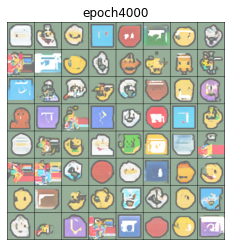

checkpoint
Epoch [4010/10000][28/28] - loss_g: 14.2621, loss_d: 0.0030
Epoch [4020/10000][28/28] - loss_g: 14.5637, loss_d: 0.0111
Epoch [4030/10000][28/28] - loss_g: 13.2211, loss_d: 0.0015
Epoch [4040/10000][28/28] - loss_g: 12.8445, loss_d: 0.0000
Epoch [4050/10000][28/28] - loss_g: 17.1514, loss_d: 0.0049
Epoch [4060/10000][28/28] - loss_g: 11.9602, loss_d: 0.0027
Epoch [4070/10000][28/28] - loss_g: 15.5936, loss_d: 0.0001
Epoch [4080/10000][28/28] - loss_g: 14.7062, loss_d: 0.0003
Epoch [4090/10000][28/28] - loss_g: 13.7209, loss_d: 0.0007
Epoch [4100/10000][28/28] - loss_g: 8.2729, loss_d: 0.0024


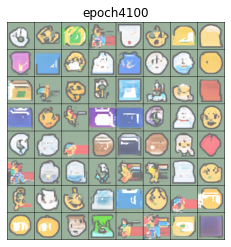

Epoch [4110/10000][28/28] - loss_g: 11.1295, loss_d: 0.0008
Epoch [4120/10000][28/28] - loss_g: 16.6489, loss_d: 0.0003
Epoch [4130/10000][28/28] - loss_g: 12.1278, loss_d: 0.0000
Epoch [4140/10000][28/28] - loss_g: 15.3266, loss_d: 0.0003
Epoch [4150/10000][28/28] - loss_g: 10.9110, loss_d: 0.0017
Epoch [4160/10000][28/28] - loss_g: 8.3197, loss_d: 0.0000
Epoch [4170/10000][28/28] - loss_g: 10.7493, loss_d: 0.0170
Epoch [4180/10000][28/28] - loss_g: 13.6232, loss_d: 0.0290


In [ ]:


timestamp = time.time()
local_time = time.localtime(timestamp)
formatted_time = time.strftime("%Y-%m-%d_%H-%M-%S", local_time)
folder_dir = "./generated_images/" + formatted_time
# create the folder to save the generated_images
os.mkdir(folder_dir)

t0 = time.time()
for epoch in range(1, args.epochs + 1):
    t0_i = time.time()
    for idx, imgs in enumerate(loader, start=1):
        imgs = imgs.to(device)
        gt_real = torch.ones(imgs.shape[0], 1).to(device)
        gt_fake = torch.zeros(imgs.shape[0], 1).to(device)

        # ---------------------------
        #  1. Train the discriminator
        # ---------------------------
        
        """
        Sample a batch of noise samples from Gaussian distribution.
        """
        z = None
        ################################
        # Your code starts here
        ################################
        z = torch.zeros(args.batch_size, args.latent_dim).to(device)
        for i in range(args.batch_size):
            z[i] = torch.randn(args.latent_dim).to(device)

        ################################
        # Your code ends here
        ################################
        assert z.shape == torch.Size([args.batch_size, args.latent_dim])

        
        """
        Compute loss for the discriminator, denoted as loss_d
        loss_d has two parts: loss for the real images L_real and loss for the fake images L_fake. Use the given criterion
        and gt_real/gt_fake to compute L_real/L_fake.
        compute loss_d as loss_d = (L_real + L_fake) / 2
        """
        loss_d = None
        imgs_fake = model_g(z)
       
        imgs_real = imgs.to(device)
        # stop gradient flowing back to the generator
        pred_fake = model_d(imgs_fake.detach())
        pred_real = model_d(imgs_real)
        
        L_real = criterion(pred_real, gt_real)
        L_fake = criterion(pred_fake, gt_fake)
        
        loss_d = (L_real + L_fake) / 2

        optimizer_D.zero_grad()
        loss_d.backward()
        optimizer_D.step()

        loss_g = None
        pred_fake = model_d(imgs_fake)
        loss_g = criterion(pred_fake, gt_real)
        
        optimizer_G.zero_grad()
        loss_g.backward()
        optimizer_G.step()

        if (epoch % 10  == 0) and (idx == len(loader)):
            print(f'Epoch [{epoch}/{args.epochs}][{idx}/{num_iters}] - '
                  f'loss_g: {loss_g.item():.4f}, loss_d: {loss_d.item():.4f}')

    if epoch % args.save_interval == 0:
        # save the imgs
        filename = "epoch_" + str(epoch) + ".png"
        file_dir = folder_dir + "/" + filename
        save_image(imgs_fake[:args.batch_size].cpu(), file_dir)
        subfolder_dir = folder_dir + "/" + "epoch_" + str(epoch)
        os.mkdir(subfolder_dir)
        for i in range(len(imgs_fake[:args.batch_size].cpu())):
          filename = "epoch_" + str(epoch) + "_idx_" + str(i) + ".png"
          file_dir = subfolder_dir + "/" + filename
          save_image(imgs_fake[i].cpu(), file_dir)
        
        img_grid = tensor2PIL(make_grid(imgs_fake[:args.batch_size].cpu(), nrow=int(math.sqrt(args.batch_size)), normalize=True))
        display_image(img_grid, title=f'epoch{epoch}')
    
    # t1_i = time.time()
    # t_i = format_time(t1_i - t0_i)
    # print(f'Epoch [{epoch}] training time: {t_i}')
    if epoch % args.checkpoint == 0:
      torch.save(model_g.state_dict(), folder_dir +'/epoch_' + str(epoch) + '_model_g.pth')
      torch.save(model_d.state_dict(), folder_dir +'/epoch_' + str(epoch) + '_model_d.pth')
      print('='*10)
      print("checkpoint")
      print('='*10)
t1 = time.time()
tot = format_time(t1 - t0)
print(f'Total training time: {tot}')
# save model
torch.save(model_g.state_dict(), folder_dir + '/model_g.pth')
torch.save(model_d.state_dict(), folder_dir + '/model_d.pth')

In [4]:
import numpy as np
# get the best 5 emojis
best_5_data_path = 'best_5'
best_5_lst_file = 'best_5/lst.txt'
# create the dataset object
best_5_dataset = EmojiDataset(root_dir=best_5_data_path, lst_file=best_5_lst_file, transform=PIL2tensor)
best_5_loader = torch.utils.data.DataLoader(best_5_dataset, num_workers=10)
emoji_loader = torch.utils.data.DataLoader(dataset, num_workers=10)

album = {"emojis_g":list(), 
      "emojis_r":list(),
      "dist":list()}
for idx_g, img_g in enumerate(best_5_loader):
  img_g = img_g[0]
  album['emojis_g'].append(tensor2PIL(img_g))
  distances = np.zeros(len(emoji_loader))
  imgs = []
  for idx_r, img_r in enumerate(emoji_loader):
    # calculate the distances
    img_r = img_r[0]
    imgs.append(img_r)
    img_g, img_r = img_g.to(device), img_r.to(device)
    distances[idx_r] = F.mse_loss(img_r, img_g).item()
  closest_idx = np.argmin(distances)
  album['emojis_r'].append(tensor2PIL(imgs[closest_idx]))
  album['dist'].append(distances[closest_idx])

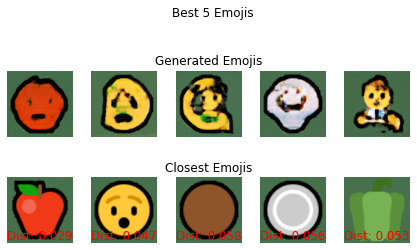

In [9]:
# draw the album
fig, ax = plt.subplots(2,5)
for i in range(5):
  ax[0,i].imshow(album['emojis_g'][i])
  ax[0,i].axis('off')
  ax[1,i].imshow(album['emojis_r'][i])
  ax[1,i].axis('off')
  ax[1,i].text(0, 0, "Dist: " + str(format(album['dist'][i], '.3f')), fontsize=12, color='red', horizontalalignment='left', verticalalignment='bottom', transform=ax[1,i].transAxes)
  
plt.suptitle("Best 5 Emojis")
plt.tight_layout()
ax[0, 2].set_title("Generated Emojis")
ax[1, 2].set_title("Closest Emojis")
plt.savefig('album.png')
plt.show()